# Exercise session 4: Gradient descent and quasi-Newton methods
### 1. Preliminaries and problem set-up
First, we will set up the Python environment. To this end, we will import three modules:
- **Numpy**: package for multi-dimensional arrays
- **time**: package for measuring computation time
- **matplotlib**: package for plotting results


In [49]:
%matplotlib inline
import numpy as np
import time
import matplotlib.pyplot as plt
import warnings

In Exercise session 2, we have used *scipy.optimize.linprog* to solve linear programs. In this Exercise Session, we will write our own minimization algorithms for minimizing nonlinear objective functions, ignoring constraints for now. More specifically, we will handle problems of the form
$$
    \min_{x \in \mathbb{R}^n} f(x),
$$
where $f : \mathbb{R}^n \rightarrow \mathbb{R}$ is a convex, continuously differentiable function.

To compare the different optimization methods considered in this exercise session, we introduce three different functions which will be minimized.
The first function is a simple toy function, given by
$$
    f_{toy}(x) = x_0^2 + 2 x_1^2
$$
of which the gradient is given by
$$
    \nabla f_{toy}(x) = \begin{bmatrix} 2x_0 \\ 4x_1\end{bmatrix}
$$
and the Hessian by
$$
    \nabla^2 f_{toy}(x) = \begin{bmatrix} 2 & \\ & 4\end{bmatrix}.
$$
This function has a single global minimizer at $x^\star = (0, 0)^\top$

In [50]:
def toy_fun(x):
    return x[0]**2 + 2*x[1]**2

def toy_grad(x):
    return np.array([2*x[0], 4*x[1]])

def toy_hess(x):
    return np.diag([2,4])

### Exercise 1: Rosenbrock function
The second function considered in this session is the Rosenbrock function, given by
$$
    f_{rosen}(x) = (1 - x_0)^2 + 100(x_1 - x_0^2)^2,
$$

- (a) Compute the gradient of $f_{\rm rosen}$.
- (b) Compute the Hessian of $f_{\rm rosen}$.
- (c) Show that $x^*=(1,1)^T$ is the only stationary point of the function.
- (d) Show that the Hessian matrix at $x^*$ is positive definite. Deduce that $x^*$ is a local minimizer.
- (e) Implement $f_{\rm rosen}, \nabla f_{\rm rosen}$ and $\nabla^2 f_{\rm rosen}$ below.

In [51]:
def rosenbrock_fun(x):
    return (1 - x[0])**2 + 100*(x[1] - x[0]**2)**2

def rosenbrock_grad(x):
    return np.array([-2*(1 - x[0])-400*(x[1] - x[0]**2) * x[0], 200*(x[1]-x[0]**2)])

def rosenbrock_hess(x):
    return np.array([[2 - 400 * x[1] + 1200 * x[0]**2, -400 * x[0]], [-400 * x[0], 200]])

### Exercise 2: Gradient descent method
The most simple algorithm for minimizing a continuously differentiable objective function is the gradient descent method. In this method, as the name suggests, a step in the direction of the gradient of the objective function is taken at each iteration, with step length given by some parameter $\alpha_k$. In other words, a series of iterates is generated starting from some initial guess $x_0 \in \mathbb{R}^n$, satisfying
\begin{align*}
    d_k {}={}& - \nabla f(x_k)\\
    x_{k+1} {}={}& x_k + \alpha_k d_k.
\end{align*}


**Task 2a**: Implement the gradient descent method with fixed stepsize $\alpha$ by completing the function *gradient_descent*.

In [52]:
def print_info(x, iter, max_iter):
    if iter == max_iter - 1:
        print('Did not reach the desired tolerance within ' + str(max_iter) + ' outer iterations.')
    else:
        if len(x) <= 2:
            print('Converged to ' + str(x) + ' after ' + str(iter + 1) + ' outer iterations.')
        else:
            print('Converged after ' + str(iter + 1) + ' outer iterations.')

In [53]:
def gradient_descent(f, grad, x0 : np.ndarray, alpha : float, tolerance : float, max_iter : int, print = True):
    x = x0
    
    # Evaluate f and gradient
    fx = f(x)
    gradx = grad(x)
    norm_gradx = np.linalg.norm(gradx)

    # Create dictionary for storing history
    hist = {'x':[x],'f':[fx], 'norm_grad':[norm_gradx], 'time':[0]}
    tic = time.perf_counter()

    for iter in range(max_iter):
        # Perform gradient descent step to update x
        x = x - alpha * gradx

        # Evaluate f and gradient
        fx = f(x)
        gradx = grad(x)
        norm_gradx = np.linalg.norm(gradx)

        # Update history
        toc = time.perf_counter()
        hist['x'].append(x)
        hist['f'].append(fx)
        hist['norm_grad'].append(norm_gradx)
        hist['time'].append(toc-tic)

        # Stopping criterion
        if norm_gradx <= tolerance:
            break
    
    if print:
        print_info(x, iter, max_iter)

    hist['x'] = np.array(hist['x'])
    return hist

**Task 2b**: Test the gradient descent method on the toy and rosenbrock problem. Experiment with different values for the stepsize *alpha* and see how the iterations are effected. For the Rosenbrock problem, observe that gradient descent may easily diverge if *alpha* is selected too large.

Converged to [4.71611547e-05 1.15268387e-09] after 161 outer iterations.
Converged to [0.99988825 0.99977606] after 20551 outer iterations.


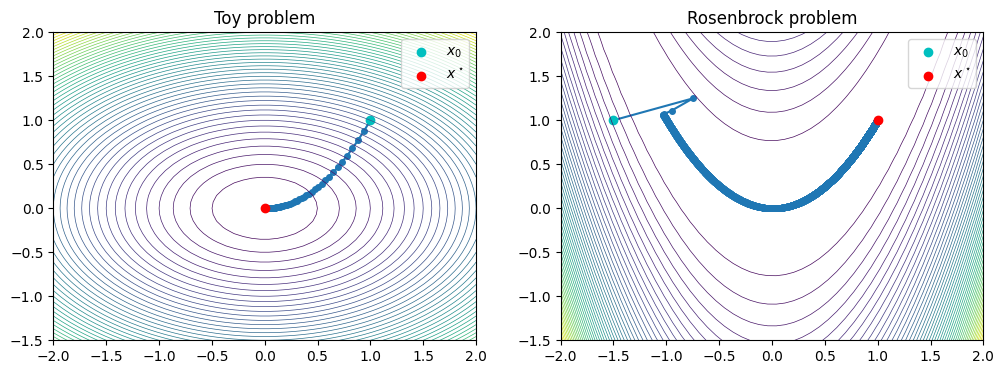

In [54]:
xlist = np.linspace(-2.0, 2.0, 50)
ylist = np.linspace(-1.5, 2, 50)
X, Y = np.meshgrid(xlist, ylist)
Z_toy = X**2 + 2*Y**2
Z_rosen = (1 - X)**2 + 100*(Y - X**2)**2

# Initialization
tolerance = 1e-4
x0_toy = np.array([1,1])
x0_rosen = np.array([-1.5,1])

# Perform gradient descent
hist_toy = gradient_descent(toy_fun, toy_grad, x0_toy, 0.03, tolerance, 25000)
hist_rosen = gradient_descent(rosenbrock_fun, rosenbrock_grad, x0_rosen, 0.001, tolerance, 25000)

# Solutions of the problems
xstar_toy = np.array([0,0])
xstar_rosen = np.array([1,1])

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(hist_toy['x'][:,0], hist_toy['x'][:,1], '-o', markersize=4, zorder=0)
ax1.scatter(x0_toy[0], x0_toy[1], c='c', zorder=1, label = '$x_0$')
ax1.scatter(xstar_toy[0], xstar_toy[1], c='r', zorder=2, label = '$x^\star$')
ax1.contour(X, Y, Z_toy, levels=50, linewidths=0.5)
ax1.set_title('Toy problem')
ax1.legend()
ax2.plot(hist_rosen['x'][:,0], hist_rosen['x'][:,1], '-o', markersize=4, zorder=0)
ax2.scatter(x0_rosen[0], x0_rosen[1], c='c', zorder=1, label = '$x_0$')
ax2.scatter(xstar_rosen[0], xstar_rosen[1], c='r', zorder=2, label = '$x^\star$')
ax2.contour(X, Y, Z_rosen, levels=50, linewidths=0.5)
ax2.set_title('Rosenbrock problem')
ax2.legend()

### Exercise 3: Gradient descent with Armijo linesearch
One problem with gradient descent is choosing a good stepsize parameter $\alpha$. If it is selected too large, the problem may diverge; if it is too small, the problem might take a long time to converge. To alleviate these issues, consider the following procedure, which selects a suitable stepsize $\alpha$ automatically.

---

**Backtracking linesearch using the Armijo condition**<br>
**Initialize**: $x_k$, $\alpha_{init} \in (0, \infty)$, $\beta \in (0, 1)$, $\sigma \in (0, 1)$
1. $\alpha_k \leftarrow \alpha_{init}$
2. **while** $k < $ max_iter **do** <br>
        $x_{trial} = x_k + \alpha_k d_k$ <br>
        **if**  $f(x_{trial}) \leq f(x_k) + \sigma \alpha_k \nabla f(x_k)^\top d_k$ **do**<br>
        &emsp; Terminate <br>
        $\alpha_k \leftarrow \beta \alpha_k$
3. **Return** $x_{trial}$

---

**Task 3a**: Implement the backtracking linesearch using the Armijo condition, by completing the function *Armijo_linesearch*.

In [55]:
def Armijo_linesearch(f, search_direction : np.ndarray, x0 : np.ndarray, fx0 : float, directional_derivative_x0 : float, alpha_init : float, beta : float, sigma : float):
    max_iter = 1000
    alpha = alpha_init
    trial_x = x0
    for iter in range(max_iter):

        # Armijo backtracking
        trial_x = x0 + alpha * search_direction
        if f(trial_x) <= fx0 + sigma * alpha * directional_derivative_x0:
            break     
        alpha = beta * alpha

    return trial_x

**Task 3b**: Based on your implementation of the backtracking linesearch from Task 3a, implement a minimizer with linesearch by completing the function *gradient_descent_Armijo*. Use the steepest descent as your step direction as before.

In [56]:
def gradient_descent_Armijo(f, grad, x0 : np.ndarray, alpha_init : float, beta : float, sigma : float, tolerance : float, max_iter : int, print = True):
    x = x0

    # Evaluate f and gradient
    fx = f(x)
    gradx = grad(x)
    norm_gradx = np.linalg.norm(gradx)

    # Create dictionary for storing history
    hist = {'x':[x],'f':[fx], 'norm_grad':[norm_gradx], 'time':[0]}
    tic = time.perf_counter()

    for iter in range(max_iter):
        # Perform gradient descent step with linesearch
        x = Armijo_linesearch(f, -gradx, x, fx, np.dot(gradx, -gradx), alpha_init, beta, sigma)

        # Evaluate f and gradient
        fx = f(x)
        gradx = grad(x)
        norm_gradx = np.linalg.norm(gradx)

        # Update history
        toc = time.perf_counter()
        hist['x'].append(x)
        hist['f'].append(fx)
        hist['norm_grad'].append(norm_gradx)
        hist['time'].append(toc-tic)

        # Stopping criterion
        if norm_gradx <= tolerance:
            break

    if print:
        print_info(x, iter, max_iter)

    hist['x'] = np.array(hist['x'])
    return hist

**Task 3c**: Test the gradient descent method with linesearch on the toy and rosenbrock problems. Make sure that the output looks reasonable. The linesearch minimizer is expected to take fewer iterations to converge than the gradient descent method with fixed stepsize.

Converged to [1.48854589e-18 2.10004732e-05] after 24 outer iterations.
Converged to [1.00009233 1.00018491] after 9190 outer iterations.


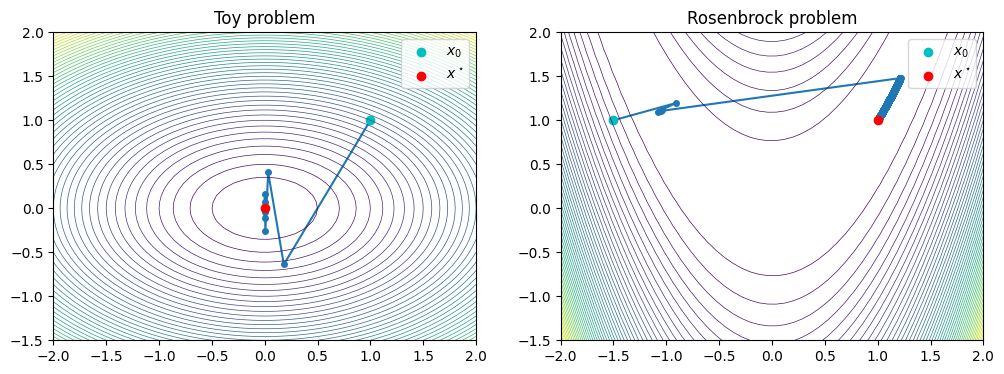

In [57]:
hist_toy = gradient_descent_Armijo(toy_fun, toy_grad, x0_toy, 1, 0.8, 1e-1, tolerance, 5000)
hist_rosen = gradient_descent_Armijo(rosenbrock_fun, rosenbrock_grad, x0_rosen, 1, 0.6, 1e-1, tolerance, 25000)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(hist_toy['x'][:,0], hist_toy['x'][:,1], '-o', markersize=4, zorder=0)
ax1.scatter(x0_toy[0], x0_toy[1], c='c', zorder=1, label = '$x_0$')
ax1.scatter(xstar_toy[0], xstar_toy[1], c='r', zorder=2, label = '$x^\star$')
ax1.contour(X, Y, Z_toy, levels=50, linewidths=0.5)
ax1.set_title('Toy problem')
ax1.legend()
ax2.plot(hist_rosen['x'][:,0], hist_rosen['x'][:,1], '-o', markersize=4, zorder=0)
ax2.scatter(x0_rosen[0], x0_rosen[1], c='c', zorder=1, label = '$x_0$')
ax2.scatter(xstar_rosen[0], xstar_rosen[1], c='r', zorder=2, label = '$x^\star$')
ax2.contour(X, Y, Z_rosen, levels=50, linewidths=0.5)
ax2.set_title('Rosenbrock problem')
ax2.legend()

### Exercise 4: Exact Newton's method
In numerical analysis, Newton's method is a numerical algorithm for finding roots of equations in one or multiple dimensions. In the context of optimization, this method can be used to find a stationary point of our objective function, i.e., finding a point $x^\star$ such that
$$
    \nabla f(x^\star) = 0,
$$
where $\nabla f : \mathbb{R}^n \rightarrow \mathbb{R}^n$.

The main idea behind Newton's method is to linearize $\nabla f$ at the current iterate $x_k$ and solve a simplified linear system of equations to obtain the new iterate $x_{k+1} = x_k + d_k$. More specifically, the linearized system is given by
\begin{align*}
    \nabla f(x_k) + \nabla^2 f(x_k) d_k = 0.
\end{align*}
Consequently, the Newton step is equal to
$$
    d_k = -(\nabla^2 f(x_k))^{-1}\nabla f(x_k),
$$
where it is implicitly assumed that $\nabla^2 f(x_k)$ is nonsingular.

**Task 4a**: Based on your implementation of the backtracking linesearch from Task 3a, implement Newton's method with linesearch by completing the function *newton*. Use the Newton step as your step direction.

In [58]:
def newton(f, grad, hess, x0 : np.ndarray, tolerance : float, max_iter : int, print = True):
    x = x0
    
    # Evaluate f, gradient and Hessian
    fx = f(x)
    gradx = grad(x)
    hessx = hess(x)
    norm_gradx = np.linalg.norm(gradx)

    # Create dictionary for storing history
    hist = {'x':[x],'f':[fx], 'norm_grad':[norm_gradx], 'time':[0]}
    tic = time.perf_counter()

    for iter in range(max_iter):
        # Perform Newton step and linesearch
        search_direction = np.linalg.solve(hessx, -gradx)
        directional_derivative = np.dot(gradx, search_direction)
        x = Armijo_linesearch(f, search_direction, x, fx, directional_derivative, 1, 0.8, 1e-1)

        # Evaluate f, gradient and Hessian
        fx = f(x)
        gradx = grad(x)
        hessx = hess(x)
        norm_gradx = np.linalg.norm(gradx)

        # Update history
        toc = time.perf_counter()
        hist['x'].append(x)
        hist['f'].append(fx)
        hist['norm_grad'].append(norm_gradx)
        hist['time'].append(toc-tic)

        # Stopping criterion
        if norm_gradx <= tolerance:
            break

    if print:
        print_info(x, iter, max_iter)
        
    hist['x'] = np.array(hist['x'])
    return hist

**Task 4b**: Test Newton's method with linesearch on the toy and rosenbrock problems, using $\alpha_{init} = 1$ for the Armijo linesearch. You should observe that Newton's method converges in a single step for the toy problem. Why does this happen?

Converged to [0. 0.] after 1 outer iterations.
Converged to [0.99999997 0.99999994] after 21 outer iterations.


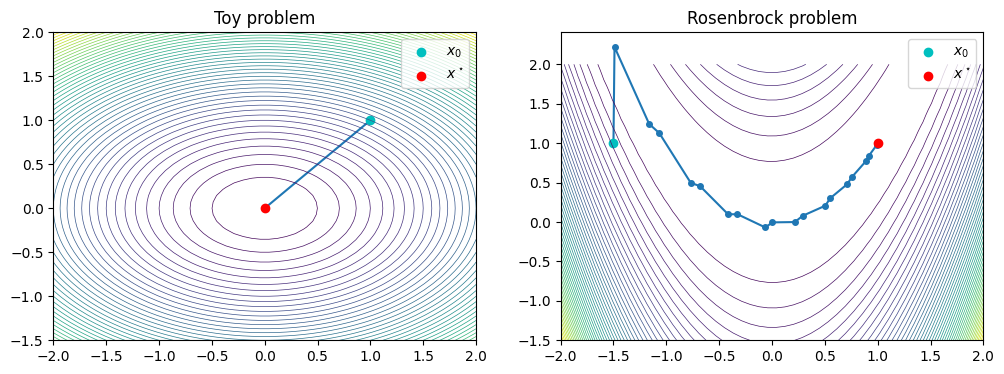

In [59]:
hist_toy = newton(toy_fun, toy_grad, toy_hess, x0_toy, tolerance, 1000)
hist_rosen = newton(rosenbrock_fun, rosenbrock_grad, rosenbrock_hess, x0_rosen, tolerance, 1000)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(hist_toy['x'][:,0], hist_toy['x'][:,1], '-o', markersize=4, zorder=0)
ax1.scatter(x0_toy[0], x0_toy[1], c='c', zorder=1, label = '$x_0$')
ax1.scatter(xstar_toy[0], xstar_toy[1], c='r', zorder=2, label = '$x^\star$')
ax1.contour(X, Y, Z_toy, levels=50, linewidths=0.5)
ax1.set_title('Toy problem')
ax1.legend()
ax2.plot(hist_rosen['x'][:,0], hist_rosen['x'][:,1], '-o', markersize=4, zorder=0)
ax2.scatter(x0_rosen[0], x0_rosen[1], c='c', zorder=1, label = '$x_0$')
ax2.scatter(xstar_rosen[0], xstar_rosen[1], c='r', zorder=2, label = '$x^\star$')
ax2.contour(X, Y, Z_rosen, levels=50, linewidths=0.5)
ax2.set_title('Rosenbrock problem')
ax2.legend()

### Exercise 5: BFGS

There are several major issues with Newton's method. Most notably, the Hessian $\nabla^2 f$ might be
- difficult to compute analytically
- not invertible
- not be positive definite (in which case the Newton step is not a direction of descent)

The goal of quasi-Newton methods is to use Newton-type steps while alleviating most of these issues. In particular, these algorithms generate an approximation of the Hessian $B_k$. One algorithm for updating the approximate Hessian $B_k$ is the famous BFGS (Broyden-Fletcher-Goldfarb-Shanno) formula. This formula updates $B_k$ based on the secant condition using only rank-two modifications and is given by
\begin{equation}\tag{5.1}
  B_{k+1} =  B_{k} + \frac{y_ky_k^\top}{y_k^\top s_k} - \frac{B_k s_ks_k^\top B_k}{s_k^\top B_k s_k} 
\end{equation}
with $s_k$ and $y_k$ defined as:
\begin{align}
  s_k  
    {}={}&
  x_{k+1} -  x_{k}, \tag{5.2a}
  \\%
  y_k  
    {}={}&
  \nabla f(x_{k+1}) - \nabla f(x_{k}).\tag{5.2b}
\end{align}
Using this approximate Hessian, the search direction $d_k$ is obtained by solving the linear equation
$$
  B_{k}d_k = -\nabla f(x_k). \tag{5.3}
$$.

Formally, minimization using BFGS is given by the following algorithm.

---

**Minimization using BFGS**<br>
**Initialize**: $x_0$, $B_{0}=I_n$, $\epsilon = 10^{-4}$ and pre-compute $\nabla f(x_0)$
1. **while** $k < $ max_iter **do** <br>
        Find $d_k$ by solving (5.3) <br>
        Find $x_{k+1}$ using the Armijo linesearch <br>
        Compute $\nabla f(x_{k+1})$ <br>
        **if** $\|\nabla f(x_{k+1})\| < \epsilon$ **do**<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Terminate <br>
        **else** <br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Compute $s_k$, $y_k$ as in (5.2) <br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Update the BFGS matrix $B_{k+1}$ as in (5.1) 
2. **Return** $x_{k+1}$, $f(x_{k+1})$

---

**Task 5a**: Based on your implementation of the backtracking linesearch from Task 3a, implement BFGS with linesearch by completing the function *BFGS*. Use the BFGS step as your step direction.

In [60]:
def BFGS(f, grad, x0 : np.ndarray, tolerance : float, max_iter : int, print = True):
    x = x0
    
    # Evaluate f and gradient
    fx = f(x)
    gradx = grad(x)
    norm_gradx = np.linalg.norm(gradx)

    # Initialize BFGS matrix
    B = np.eye(x0.shape[0])

    # Create dictionary for storing history
    hist = {'x':[x],'f':[fx], 'norm_grad':[norm_gradx], 'time':[0]}
    tic = time.perf_counter()

    for iter in range(max_iter):
        x_prev = x
        gradx_prev = gradx

        # Find search direction and perform step using Armijo
        search_direction = np.linalg.solve(B, -gradx)
        directional_derivative = gradx.T @ search_direction
        x = Armijo_linesearch(f, search_direction, x, fx, directional_derivative, 1, 0.8, 1e-1)

        # Evaluate f and gradient
        fx = f(x)
        gradx = grad(x)
        norm_gradx = np.linalg.norm(gradx)

        # Update history
        toc = time.perf_counter()
        hist['x'].append(x)
        hist['f'].append(fx)
        hist['norm_grad'].append(norm_gradx)
        hist['time'].append(toc-tic)

        # Stopping criterion
        if norm_gradx <= tolerance:
            break

        # Update BFGS matrix
        s = np.reshape(x - x_prev, (-1,1))
        y = np.reshape(gradx - gradx_prev, (-1,1))
        B = B + y @ y.T / (y.T @ s) - B @ s @ s.T @ B / (s.T @ B @ s)

    if print:
        print_info(x, iter, max_iter)

    hist['x'] = np.array(hist['x'])
    return hist

**Task 5b**: Test the minimization method using BFGS on the toy and rosenbrock problems. How does it compare to the other algorithms considered in this exercise session?

Converged to [ 4.23461275e-05 -3.44058695e-06] after 6 outer iterations.
Converged to [0.99999975 0.99999943] after 36 outer iterations.


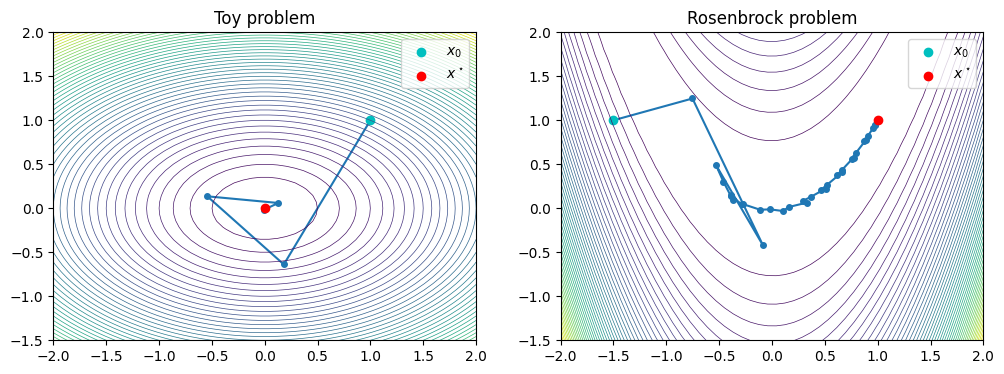

In [61]:
hist_toy = BFGS(toy_fun, toy_grad, x0_toy, tolerance, 1000)
hist_rosen = BFGS(rosenbrock_fun, rosenbrock_grad, x0_rosen, tolerance, 1000)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(hist_toy['x'][:,0], hist_toy['x'][:,1], '-o', markersize=4, zorder=0)
ax1.scatter(x0_toy[0], x0_toy[1], c='c', zorder=1, label = '$x_0$')
ax1.scatter(xstar_toy[0], xstar_toy[1], c='r', zorder=2, label = '$x^\star$')
ax1.contour(X, Y, Z_toy, levels=50, linewidths=0.5)
ax1.set_title('Toy problem')
ax1.legend()
ax2.plot(hist_rosen['x'][:,0], hist_rosen['x'][:,1], '-o', markersize=4, zorder=0)
ax2.scatter(x0_rosen[0], x0_rosen[1], c='c', zorder=1, label = '$x_0$')
ax2.scatter(xstar_rosen[0], xstar_rosen[1], c='r', zorder=2, label = '$x^\star$')
ax2.contour(X, Y, Z_rosen, levels=50, linewidths=0.5)
ax2.set_title('Rosenbrock problem')
ax2.legend()

The current implementation of BFGS does not ensure that $B_k$ remains positive definite. One way to ensure that $B_k$ remains positive definite is by ensuring that the step size $\alpha_k$ satisfies the Wolfe conditions ($0 < \sigma < \eta < 1$)

\begin{align*}
    f(x^k + \alpha d^k) {}\leq{}& f(x^k) + \alpha \sigma \nabla f(x^k)^\top d^k\\
    \nabla f(x^k + \alpha d^k)^\top d^k {}\geq{}& \eta \nabla f(x^k)^\top d^k
\end{align*}
Common choices are $\sigma = 10^{-4}$, $\eta = 0.1$. To ensure that these conditions hold, one can employ the so-called bisection method, which is given as follows.

---

**Bisection method for Wolfe conditions**<br>
**Input:** $0<\sigma<\eta<1$, $\underline{\alpha}=0$, $\overline{\alpha}=+\infty$, $\alpha_{init}=1$ <br>
1. $\alpha_k \leftarrow \alpha_{init}$
2. **while** $k < $ max_iter **do** <br>
    $x_{trial} = x_k + \alpha_k d_k$ <br>
    **if** $f(x^k + \alpha d^k) > f(x^k) + \alpha \sigma \nabla f(x^k)^\top d^k$ **do**<br>
    &emsp;$\overline{\alpha} \leftarrow \alpha$&emsp;&emsp; (decrease step) <br>
    &emsp;$\alpha_k \leftarrow \tfrac{1}{2}(\underline{\alpha}+\overline{\alpha})$<br>
    **else if** $\nabla f(x^k+\gamma d^k)^\top d^k < \eta\nabla f(x^k)^\top d^k$ **do**<br>
    &emsp;$\underline{\alpha} \leftarrow \alpha$&emsp;&emsp; (increase step) <br>
    &emsp;**if** $\overline{\alpha} = +\infty$ **do**<br>
    &emsp;&emsp;$\alpha_k \leftarrow 2\underline{\alpha}$<br>
    &emsp;**else**<br>
    &emsp;&emsp;$\alpha_k \leftarrow \tfrac{1}{2}(\underline{\alpha}+\overline{\alpha})$<br>
3. **Return** $x_{trial}$

---

**Task 5d**: Update your implementation of BFGS from task 5a, using the bisection method instead of the Armijo linesearch.

In [62]:
def bisection_method(f, grad, search_direction : np.ndarray, x0 : np.ndarray, fx0 : float, directional_derivative_x0 : float, sigma: float, eta: float):
    max_iter = 1000
    alpha = 1
    alpha_l = 0
    alpha_u = np.inf

    trial_x = x0
    for iter in range(max_iter):
        trial_x = x0 + alpha * search_direction
        if f(trial_x) > fx0 + sigma * alpha * directional_derivative_x0:
            alpha_u = alpha
            alpha = 0.5 * (alpha_l + alpha_u)
        elif np.dot(grad(trial_x), search_direction) < eta * directional_derivative_x0:
            alpha_l = alpha
            if alpha_u == np.inf:
                alpha = 2 * alpha_l
            else:
                alpha = 0.5 * (alpha_l + alpha_u)
        else:
            break
    return trial_x

### Exercise 6: Logistic regression
As a final, real-world example, consider the logistic regression function previously discussed in Exercise Session 1. This function is given by
$$
    f_{log} = \frac{1}{N} \sum_{i=1}^N \log(1 + \exp{-b_i(x^\top a_i)}) + \frac{\mu}{2N}||x||_2^2
$$
Let 
$$
    \sigma_i 
        {}:={}
    \frac{1}{1 + \exp{-b_i(x^\top a_i)}},
    \qquad
    A 
        {}:={}
    \begin{bmatrix}
        a_1^\top\\
        \vdots\\
        a_N^\top
    \end{bmatrix},
    \qquad
    s
        {}:={}
    \begin{bmatrix}
        b_1(\sigma_1 - 1)\\
        \vdots\\
        b_N(\sigma_n - 1)
    \end{bmatrix}
    \quad \text{and} \quad
    \Sigma
        {}:={}
    \begin{bmatrix}
        \sigma_1(1-\sigma_1) & & \\
        & \ddots & \\
        & & \sigma_N(1 - \sigma_N)
    \end{bmatrix}
$$
Then, as shown in Exercise Session 1 the gradient is given by 
$$
    \nabla f_{log} = \frac{1}{N} A^\top s + \frac{\mu}{N} x
$$
and the Hessian by
$$
    \nabla^2 f_{log} = \frac{1}{N} A^\top \Sigma A + \frac{\mu}{N} I_n.
$$

In [63]:
def logistic_regression_fun(x, A, b, mu):
    [N, n] = A.shape
    sigma_inv = 1 + np.exp(- b * (A @ x))
    return (1/N)*np.sum(np.log(sigma_inv)) + (mu/(2*N))*np.linalg.norm(x)**2

def logistic_regression_grad(x, A, b, mu):
    [N, n] = A.shape
    sigma_inv = 1 + np.exp(- b * (A @ x))
    sigma  = 1/sigma_inv
    return (1/N)*A.T @ (b*(sigma-1)) + (mu/N) * x

def logistic_regression_hess(x, A, b, mu):
    [N, n] = A.shape
    sigma_inv = 1 + np.exp(- b * (A @ x))
    sigma  = 1/sigma_inv
    Sigma = np.diag(sigma*(1-sigma))
    return (1/N)*A.T @ Sigma @ A + (mu/N) * np.eye(n)

The datasets considered in this exercise session are the a1a dataset, where we aim to predict whether a person makes \$50000 a year based on social features (age, education, gender...), and the colon-cancer dataset previously discussed in exercise session 1. 

In [64]:
from sklearn.datasets import load_svmlight_file

A_a1a, b_a1a = load_svmlight_file("./datasets/a1a", n_features = 123)
A_a1a = A_a1a.toarray()

A_colon, b_colon = load_svmlight_file("./datasets/colon-cancer", n_features=2000)
A_colon = A_colon.toarray()

def Lipschitz(A, mu):
    [N, n] = A.shape
    return (1/(4*N))*np.linalg.norm(A_a1a,2)**2 + mu/N

def condition_number(A, mu):
    [N, n] = A.shape
    return Lipschitz(A, mu)/(mu/N)

print("a1a dataset: N = " + str(A_a1a.shape[0]) + ", n = " + str(A_a1a.shape[1]))
print("colon-cancer dataset: N = " + str(A_colon.shape[0]) + ", n = " + str(A_colon.shape[1]))

a1a dataset: N = 1605, n = 123
colon-cancer dataset: N = 62, n = 2000


**Task 6a**: Test the gradient descent method with and without linesearch on the logistic regression problem. Test both the *a1a* and the *colon-cancer* datasets and for regularizer $\mu$ equal to $100$, $1$ and $0.01$. What do you observe when you decrease the regularizer? What is the relation with the condition number of the problem? Why is the performance of Newton's method and BFGS significantly worse for the *colon-cancer* dataset in terms of computation time? *hint: Look at the number of datapoints and features of each dataset.*

In [65]:
def test_dataset(A, b, mu):
    x0 = np.zeros(A.shape[1])
    Lf = Lipschitz(A, mu)

    f, g, h = lambda x: logistic_regression_fun(x, A, b, mu), lambda x: logistic_regression_grad(x, A, b, mu), lambda x: logistic_regression_hess(x, A, b, mu), 
    hist_g = gradient_descent(f, g, x0, 1/Lf, tolerance, 10000, print=False)
    hist_ls = gradient_descent_Armijo(f, g, x0, 100/Lf, 0.5, 1e-1, tolerance, 5000, print=False)
    hist_n = newton(f, g, h, x0, tolerance, 100, print=False)
    hist_bfgs = BFGS(f, g, x0, 1e-4, 500, print=False)

    f_star = min(hist_g['f'][-1], hist_ls['f'][-1], hist_bfgs['f'][-1], hist_n['f'][-1])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('regularization = ' + str(mu) +  ', N = ' + str(str(A.shape[0])) + ', n = ' + str(A.shape[1]) + ', condition number \u2248 ' + str(round(condition_number(A, mu))))
    ax1.semilogy((hist_g['f'] - f_star)/abs(f_star), label='gradient descent')
    ax1.semilogy((hist_ls['f'] - f_star)/abs(f_star), label='gradient descent + Armijo')
    ax1.semilogy((hist_n['f'] - f_star)/abs(f_star), label='Newton')
    ax1.semilogy((hist_bfgs['f'] - f_star)/abs(f_star), label='BFGS')
    ax1.set_xlabel('k')
    ax1.set_ylabel(r'$|f(x^k) - f^\star|/|f^\star|$')
    ax1.set_xlim(left=0, right = 300)
    ax1.set_ylim(top = 1e2, bottom = 1e-4)
    ax1.legend()

    ax2.semilogy(hist_g['time'], (hist_g['f'] - f_star)/abs(f_star), label='gradient descent')
    ax2.semilogy(hist_ls['time'], (hist_ls['f'] - f_star)/abs(f_star), label='gradient descent + Armijo')
    ax2.semilogy(hist_n['time'], (hist_n['f'] - f_star)/abs(f_star), label='Newton')
    ax2.semilogy(hist_bfgs['time'], (hist_bfgs['f'] - f_star)/abs(f_star), label='BFGS')
    ax2.set_xlabel('time [s]')
    ax2.set_ylabel(r'$|f(x^k) - f^\star|/|f^\star|$')
    ax2.set_xlim(left=0, right = 1)
    ax2.set_ylim(top = 1e2, bottom = 1e-4)
    ax2.legend()

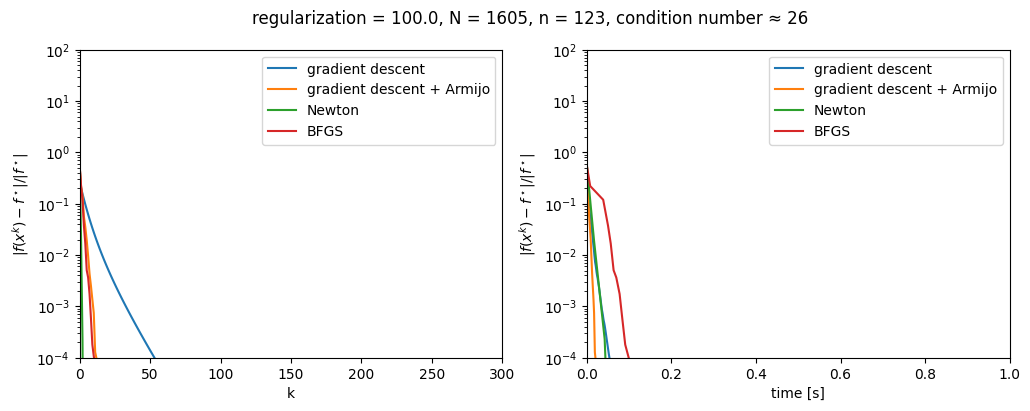

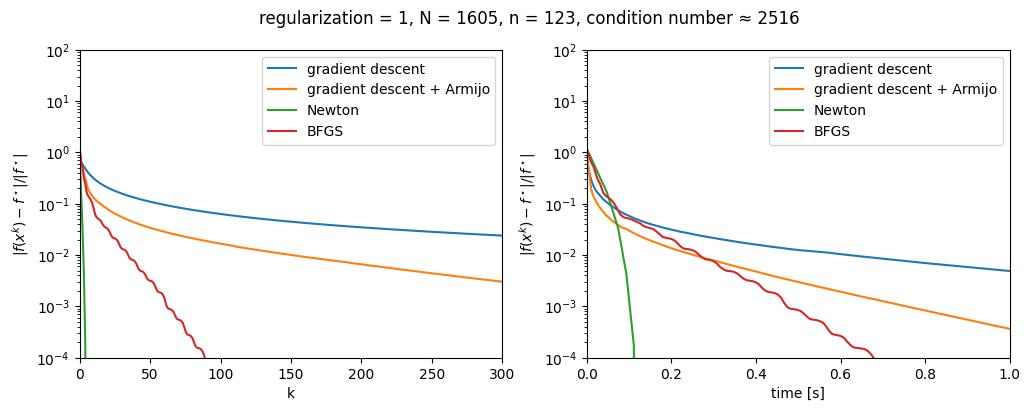

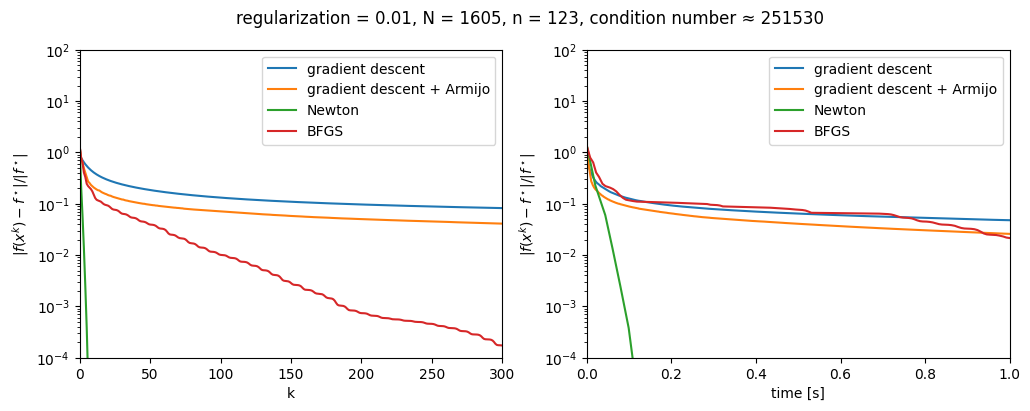

In [66]:
test_dataset(A_a1a, b_a1a, 1e2)
test_dataset(A_a1a, b_a1a, 1)
test_dataset(A_a1a, b_a1a, 1e-2)

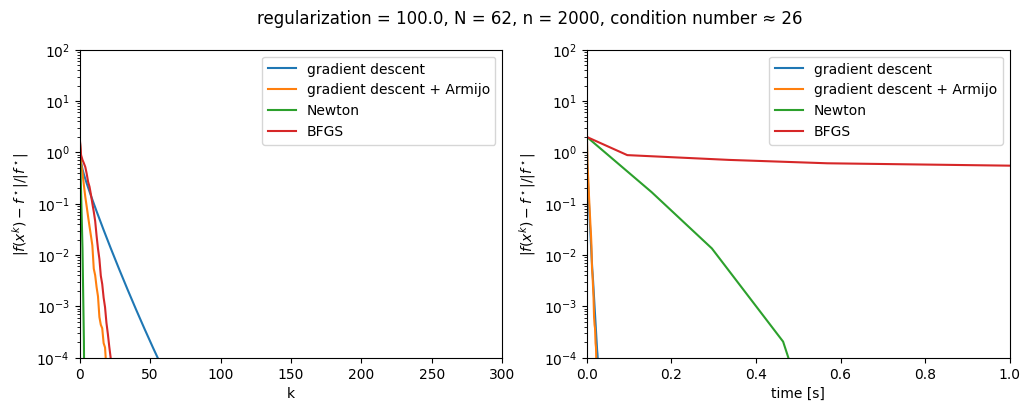

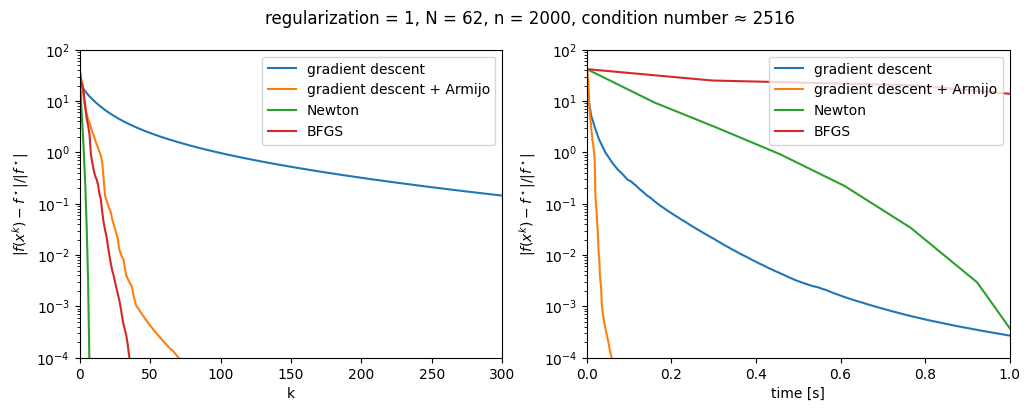

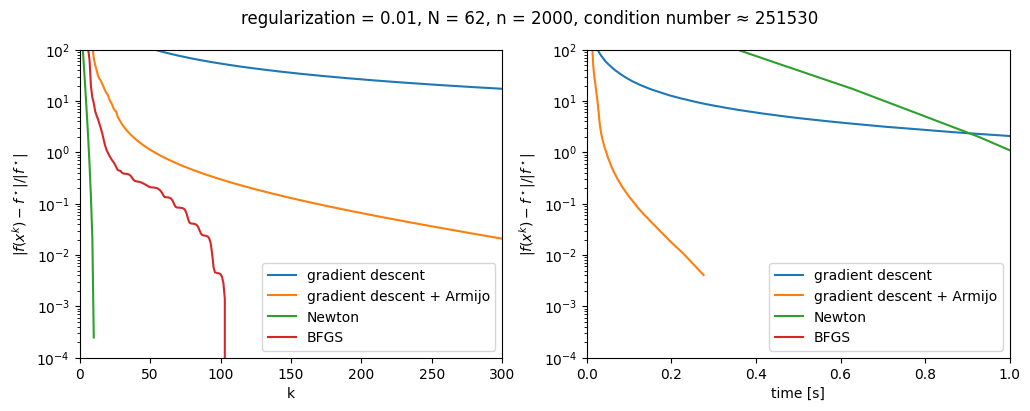

In [67]:
test_dataset(A_colon, b_colon, 1e2)
test_dataset(A_colon, b_colon, 1)
test_dataset(A_colon, b_colon, 1e-2)